In [28]:
#Import Libraries
!pip install tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt
import plotly.graph_objects as go
import plotly.io as pio
import IPython
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import warnings

#Mute Sklearn Warning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [29]:
#Import dataset
data = pd.read_csv('Data Historis BYAN.csv')

#Displaying 5 first rows
data.head()

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,30/12/2024,20.250,20.350,20.400,20.000,"152,90K","0,25%"
1,27/12/2024,20.200,20.350,20.400,20.125,"80,40K","-0,74%"
2,24/12/2024,20.350,20.325,20.400,20.075,"79,60K","0,12%"
3,23/12/2024,20.325,20.375,20.475,19.925,"119,30K","-0,25%"
4,20/12/2024,20.375,20.300,20.400,20.000,"146,20K","0,37%"


In [30]:
#Check Number of row and missing values
print('Number of rows and columns', data.shape)
print('Number of missing values', data.isnull().sum())

Number of rows and columns (1081, 7)
Number of missing values Tanggal       0
Terakhir      0
Pembukaan     0
Tertinggi     0
Terendah      0
Vol.          0
Perubahan%    0
dtype: int64


In [31]:
# Resolving Missing values
data.dropna(inplace=True)
data.isnull().sum()

,0
Tanggal,0
Terakhir,0
Pembukaan,0
Tertinggi,0
Terendah,0
Vol.,0
Perubahan%,0


In [32]:
# Replace 'Tanggal' with the actual column name if different
data['Tanggal'] = pd.to_datetime(data['Tanggal'], format='%d/%m/%Y')

# Rename the 'Tanggal' column to 'Date'
data.rename(columns={'Tanggal': 'Date'}, inplace=True)

# Drop duplicate rows based on the 'Date' column, keeping the first occurrence
data.drop_duplicates(subset=['Date'], keep='first', inplace=True)

# Sort data by ‘Date’ column in ascending order (2020 - 2024)
data = data.sort_values(by=['Date'])

# Mengatur ulang indeks setelah pengurutan
data = data.reset_index(drop=True)
data.head()

,Date,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,2020-01-03,15.55,15.55,15.55,15.55,"0,10K","-2,20%"
1,2020-01-07,15.55,15.55,15.55,15.55,"1,00K","0,00%"
2,2020-01-08,15.55,15.55,15.55,15.55,"0,20K","0,00%"
3,2020-01-09,15.55,15.55,15.55,15.55,"0,10K","0,00%"
4,2020-01-10,15.75,15.55,15.75,15.55,"1,20K","1,29%"


In [33]:
# Rename columns correctly
data.rename(columns={
    'Tanggal': 'Date',
    'Terakhir': 'Last Price',
    'Pembukaan': 'Opening Price',
    'Tertinggi': 'High Price',
    'Terendah': 'Low Price',
    'Vol.': 'Volume',  # Fixing the "Volume" column
    'Perubahan%': 'Change (%)'  # Fixing the "Change (%)" column
}, inplace=True)

# Ensure "Volume" exists before processing
if 'Volume' in data.columns:
    # Convert "Volume" to string, remove unnecessary characters
    data['Volume'] = data['Volume'].astype(str).str.replace('-', '').str.replace('K', '').str.replace(',', '')

    # Convert non-empty values to float and multiply by 1000
    data['Volume'] = pd.to_numeric(data['Volume'], errors='coerce') * 1000
else:
    print("Column 'Volume' not found!")

# Ensure "Change (%)" exists before processing
if 'Change (%)' in data.columns:
    data['Change (%)'] = data['Change (%)'].astype(str).str.replace('%', '').str.replace(',', '.').astype(float)
else:
    print("Column 'Change (%)' not found!")

# Display the first few rows after conversion
data.head()

,Date,Last Price,Opening Price,High Price,Low Price,Volume,Change (%)
0,2020-01-03,15.55,15.55,15.55,15.55,10000.0,-2.20
1,2020-01-07,15.55,15.55,15.55,15.55,100000.0,0.00
2,2020-01-08,15.55,15.55,15.55,15.55,20000.0,0.00
3,2020-01-09,15.55,15.55,15.55,15.55,10000.0,0.00
4,2020-01-10,15.75,15.55,15.75,15.55,120000.0,1.29


In [34]:
#Checking datatypes
data.info()

#Checking data columns
data.columns

#Understanding row and column count
print(f'Row Count: {data.shape[0]}')
print(f'Column Count: {data.shape[1]}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1081 entries, 0 to 1080
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1081 non-null   datetime64[ns]
 1   Last Price     1081 non-null   float64       
 2   Opening Price  1081 non-null   float64       
 3   High Price     1081 non-null   float64       
 4   Low Price      1081 non-null   float64       
 5   Volume         979 non-null    float64       
 6   Change (%)     1081 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 59.2 KB
Row Count: 1081
Column Count: 7


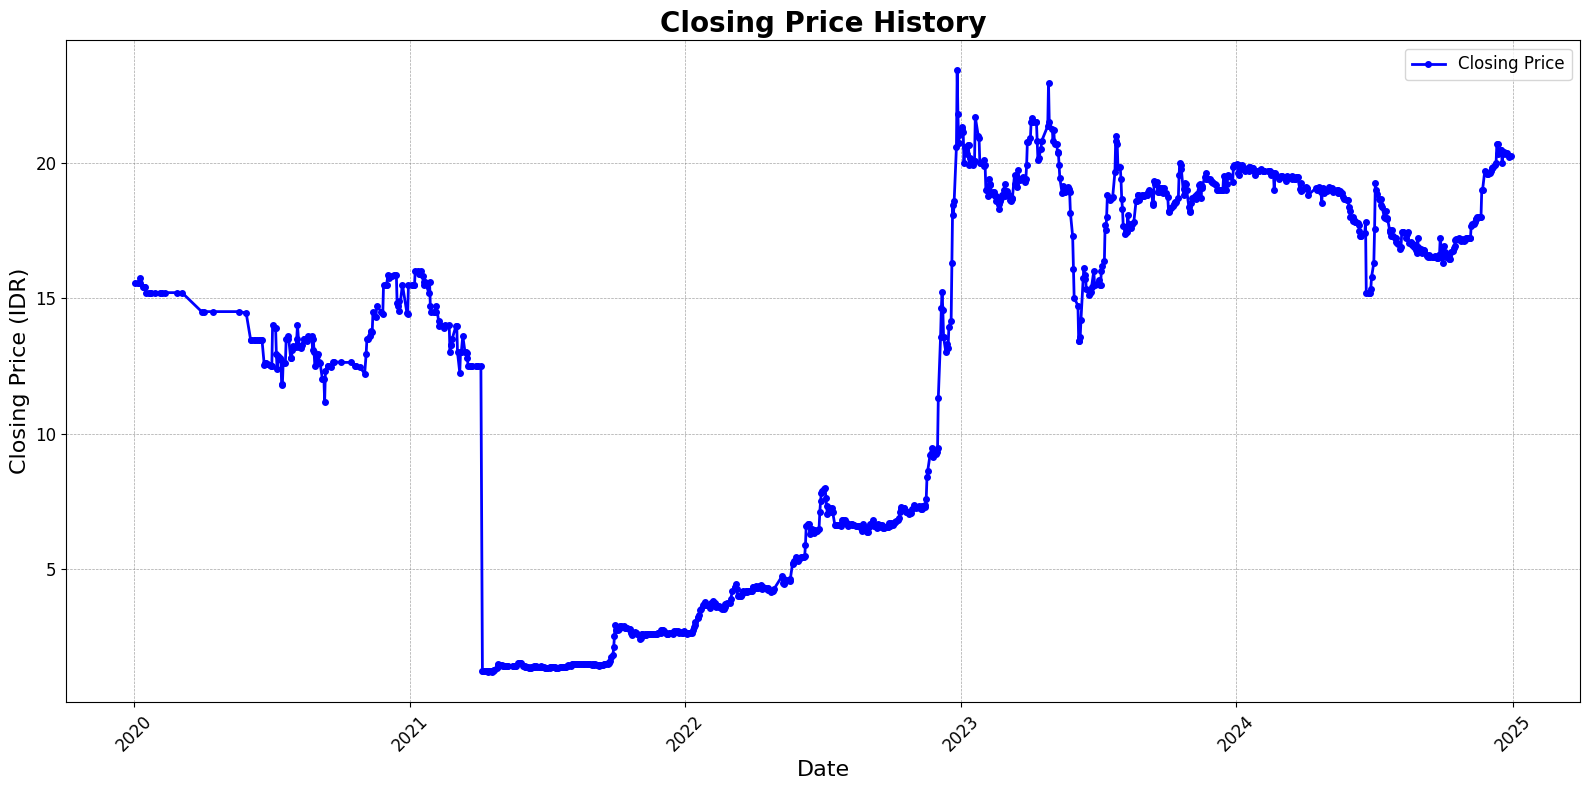

In [35]:
#History of closing stock prices
plt.figure(figsize=(16, 8))
plt.title('Closing Price History', fontsize=20, fontweight='bold')
# Assuming 'Last Price' column represents the closing price
plt.plot(data['Date'], data['Last Price'], color='blue', linewidth=2, marker='o', markersize=4, label='Closing Price')

# x-axis format (date)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Closing Price (IDR)', fontsize=16)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Adding grid
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Adding legend
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

In [36]:
#Considering the 'Last Price' column as the Closing Price
closes_prices = data['Last Price'].values

#Converting the array into a 2D one
closes_prices = closes_prices.reshape(-1, 1)

#Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
closes_scaled = scaler.fit_transform(closes_prices)
closes_scaled[:10]

array([[0.64634861],
       [0.64634861],
       [0.64634861],
       [0.64634861],
       [0.65535883],
       [0.63959094],
       [0.63959094],
       [0.63959094],
       [0.63959094],
       [0.63058071]])

In [37]:
#Using 80% data as training set
l=math.ceil(len(closes_scaled)*0.8)
trained_data = closes_scaled[:l,:]
trained_data[:10]

array([[0.64634861],
       [0.64634861],
       [0.64634861],
       [0.64634861],
       [0.65535883],
       [0.63959094],
       [0.63959094],
       [0.63959094],
       [0.63959094],
       [0.63058071]])

In [38]:
n_steps = 30 #time step variabel:
n_features = 1
X_train = []
y_train = []
for i in range(n_steps, len(trained_data)):
    X_train.append(trained_data[i-n_steps:i, 0])
    y_train.append(trained_data[i, 0])

X_train=np.array(X_train)
y_train=np.array(y_train)

In [39]:
# Test data to evaluate model performance:
test_data = closes_scaled[l-n_steps:, :]

X_test = []
y_test = closes_scaled[l:, :]
for i in range(n_steps, len(test_data)):
    X_test.append(test_data[i-n_steps:i, 0])

X_test = np.array(X_test)

In [40]:
#Converts the input data form to (n_rows, window_size, 1)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [41]:
def mape(y_true, y_pred):
    loss = np.mean(np.abs((y_true - y_pred) / y_true) - 1)
    return loss

In [42]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 30, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 30, 100)             │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 30, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 25)                  │           2,525 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 204,151 (797.46 KB)

 Trainable params: 204,151 (797.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 101ms/step - loss: 0.0587
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.0077
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0047
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0053
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0041
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0044
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0024
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0033
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0033
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0024


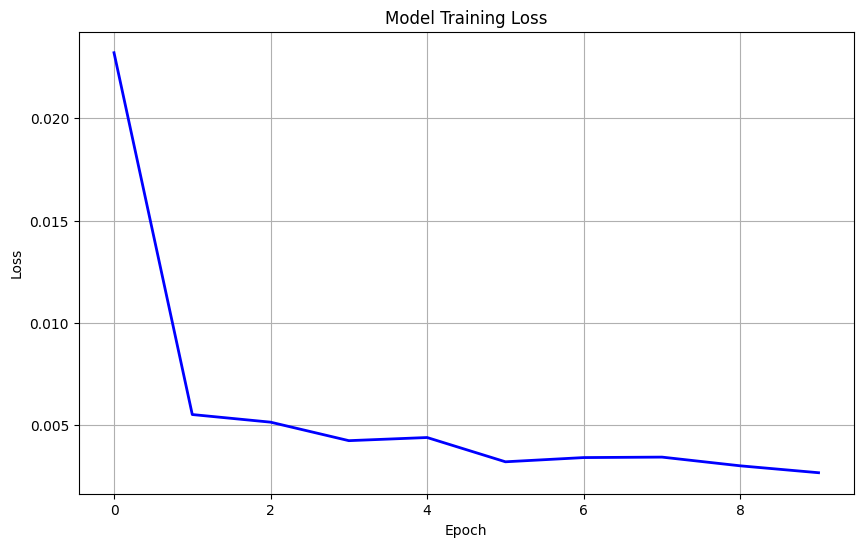

In [43]:
# Compile and fit the model
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=10, batch_size=16, verbose=1)

# Create a static plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], color='blue', linewidth=2)
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [44]:
X_train.shape, X_test.shape

((835, 30, 1), (216, 30, 1))

In [45]:
pred_ = {}

In [46]:
# Selecting the training data
train = pd.DataFrame(data)[0:l]

# Selecting the validation data
valid = pd.DataFrame(data)[l:]

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step


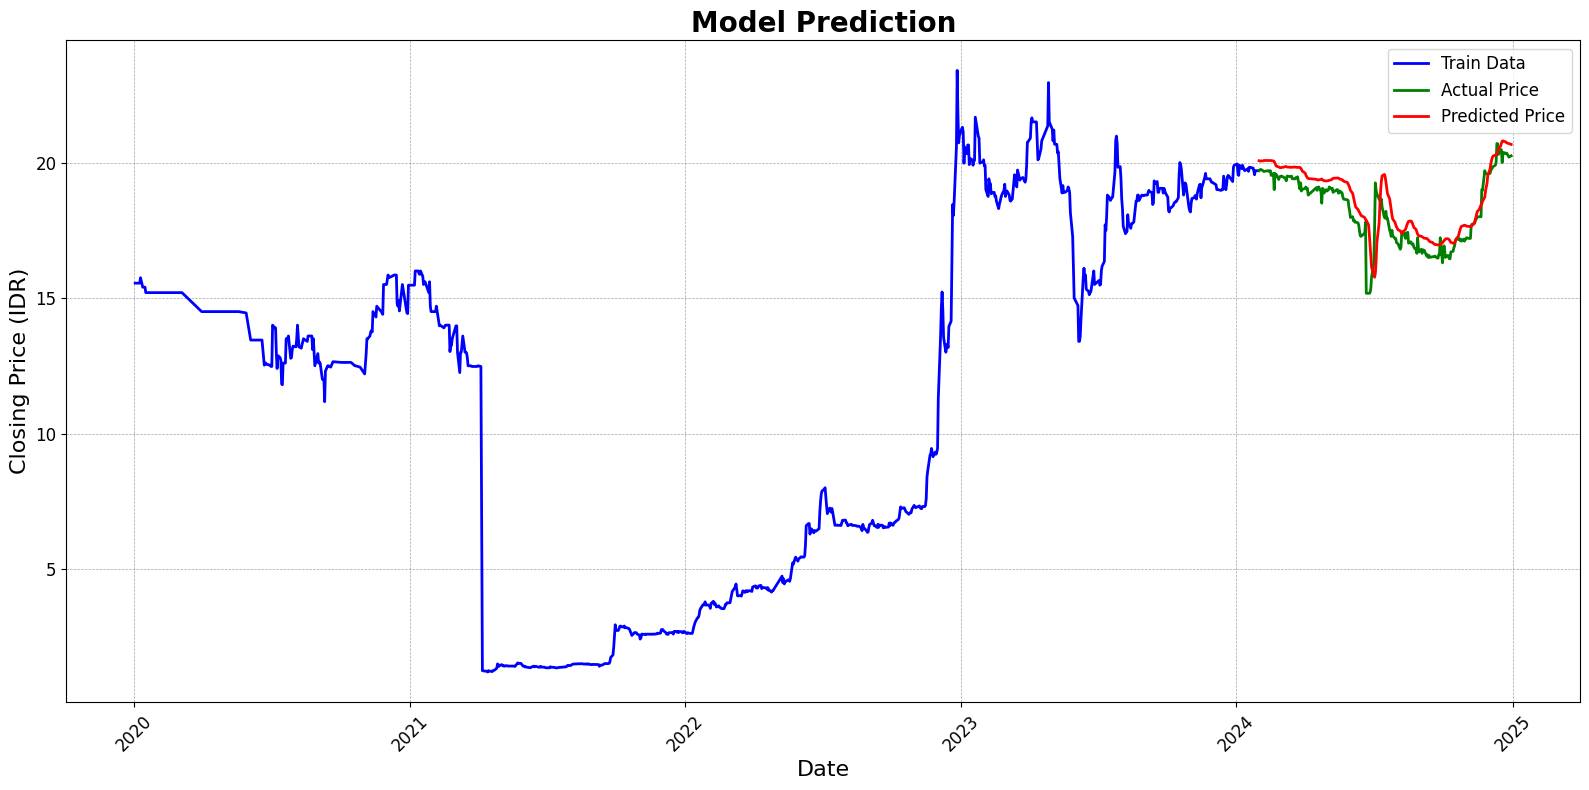


MSE Loss: 318.4665
RMSE Loss: 17.8456
MAPE Loss: 2334.94%



In [47]:
# Selecting the training and validation data
train = pd.DataFrame(data).iloc[:l]
valid = pd.DataFrame(data).iloc[l:]

# Resetting the index and setting "Date" as the index
train = train.reset_index().set_index("Date")
valid = valid.reset_index().set_index("Date")

# Make predictions with the model
pred = model.predict(X_test)

# Inverse scaling to return predictions to the original scale
pred = scaler.inverse_transform(pred)

# Make a copy to avoid SettingWithCopyWarning
valid_copy = valid.copy()
valid_copy["Prediksi"] = pred

# Create a static plot using Matplotlib
plt.figure(figsize=(16, 8))
plt.title('Model Prediction', fontsize=20, fontweight='bold')

# Plotting training data
plt.plot(train.index, train["Last Price"], color='blue', linewidth=2, label='Train Data')

# Plotting actual price
plt.plot(valid_copy.index, valid_copy["Last Price"], color='green', linewidth=2, label='Actual Price')

# Plotting predicted price
plt.plot(valid_copy.index, valid_copy["Prediksi"], color='red', linewidth=2, label='Predicted Price')


# x-axis format (date)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Closing Price (IDR)', fontsize=16)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Adding grid
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Adding legend
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


# Evaluate the model's performance
mse_loss = np.mean((pred - y_test) ** 2)
rmse_loss = np.sqrt(mse_loss)

# Function for MAPE evaluation
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_loss = mean_absolute_percentage_error(y_test, pred)

# Output evaluation metrics
print(f"\nMSE Loss: {mse_loss:.4f}")
print(f"RMSE Loss: {rmse_loss:.4f}")
print(f"MAPE Loss: {mape_loss:.2f}%\n")

In [48]:
# Exporting data
data.to_csv('Stock_Dataset', index=False)